In [1]:
import torch
import numpy as np

# Filters

## Regular Weiner Filter

## Regular Butterworth Filter

## Weiner-Butterworth

In [2]:
def psf_WB_filter(psf, alpha, beta, pixelSize, depth_step, butterworth_order):
    # Assuming that there is only one peak in the lenslet

    if len(psf.shape) == 3:
        psf = psf.unsqueeze(0) # Add a dimension for the lenslets, since only one lenslet was given

    # input PSF size and center
    _, Sz, Sx, Sy = psf.shape
    Scx = (Sx+1)/2;
    Scy = (Sy+1)/2
    Scz = (Sz+1)/2
    Sox = round((Sx+1)/2)
    Soy = round((Sy+1)/2)
    Soz = round((Sz+1)/2)
    
    # Pixel size in Fourier domain
    px = 1/Sx
    py = 1/Sy
    pz = 1/Sz
    
    # Remember that the psf is in the format of [lenslet, depth, x, y]
    # Permute the PSF to the format of [lenslet, x, y, depth]
    psf = torch.permute(psf, (0, 2, 3, 1)) # [lenslet, x, y, depth]
    
    PSF_bp = torch.empty(psf.shape)
    
    psf_flip = torch.flip(psf, (1,2,3))
    OTF_flip = torch.fft.fftn(psf_flip, dim = (1,2,3))
    OTF_abs = torch.fft.fftshift(torch.abs(OTF_flip), dim = (1,2,3))
    M = torch.amax(OTF_abs, (1,2), keepdim = True) # find maximum value and position
    OTF_abs_norm = torch.div(OTF_abs, M)
    
    # Create Wiener filter
    OTF_flip_norm = OTF_flip/M
    OTF_Wiener = torch.div(OTF_flip_norm,(torch.pow(torch.abs(OTF_flip_norm),2) + alpha))
    
    # Calculate Cut-off Gain for Wiener Filter
    OTF_Wiener_abs = torch.fft.fftshift(torch.abs(OTF_Wiener))
    
    # tplane = abs(squeeze(OTF_Wiener_a   bs(:,:,Soz))); % central slice
    tplane = torch.abs(OTF_Wiener_abs[:,:,Soz]) # central slice
    tline, _ = torch.max(tplane, dim=0, keepdim=False) # Should return maximums along each row, call each depth
    
    w = np.power((np.tile(np.arange(0,Sx), (Sy,1)).T - Scx),2)+ np.power((np.tile(np.arange(0,Sy),(Sx,1)) - Scy),2)
    w = np.broadcast_to(w[...,None],w.shape+(Sz,)) + np.power(np.tile(np.arange(0,Sz).reshape(1,1,Sz),(Sx,Sy,1)) - Scz, 2) # repeat Sz in the 3rd dimension
    w = torch.from_numpy(w)
            
    if len(psf.shape) == 3:
        psf = psf.unsqueeze(0) # Add a dimension for the lenslets, since only one lenslet was given
    
    PSF_bp = torch.empty(psf.shape)
    mask = torch.empty(Sx,Sy,Sz)

    # Loop through all the lenslets
    for j in range(int(psf.shape[0])):
        # Loop through all the depths
        for i in range(int(psf.shape[3])):
            psf_numpy = psf[j,:,:,i].numpy()
            # Grab the x and y coordinates of the maximum value of the PSF
            [x,y] = np.where(psf_numpy == np.max(psf_numpy))
            
            # Grab the x and y slices of the PSF that contain the maximum value
            psf_x = psf_numpy[:,y]
            psf_y = psf_numpy[x,:]
            
            # Find the indices that are near the half-maximum of the PSF
            idx_x = (np.abs(psf_x - (psf_numpy[x,y]/2))).argmin()
            idx_y = (np.abs(psf_y - (psf_numpy[x,y]/2))).argmin()
            
            # Set the resolution cutoff by setting the resolution to the FWHM
            resx = np.abs(x - idx_x) * pixelSize
            resy = np.abs(y - idx_y) * pixelSize
            resz = depth_step # The MatLab code assumes that the resolution is the same in all directions
            
            # Frequency cutoff in terms of pixels
            tx = 1/resx/px
            ty = 1/resy/py
            tz = 1/resz/pz
            
            # to1 = max(round(Scx -tx), 1); to2 = min(round(Scx+tx), Sx);
            to1 = max(np.round(Scx - tx), 1)
            to2 = min(np.round(Scx + tx), Sx)
            
            # beta_wienerx = (tline(to1) + tline(to2))/2; % OTF frequency intensity at cutoff:x
            beta_wienerx = (tline[:,i][to1] + tline[:,i][to2])/2 # OTF frequency intensity at cutoff:x

            ee = beta_wienerx/(beta**2) - 1
            
            mask[:,:,i] = torch.div(1, torch.sqrt(1 + torch.mul(ee,(torch.pow(w[:,:,i],butterworth_order))))) # w^n = (kx/kcx)^pn
            mask[:,:,i] = torch.fft.ifftshift(mask[:,:,i]) # Butterworth Filter

        # Create Wiener-Butteworth Filter
        OTF_bp = torch.mul(mask,OTF_Wiener) # Final OTF_bp cutfoff gain: beta
            
        PSF_bp[j,:,:,:] = torch.fft.fftshift(torch.real(torch.fft.ifftn(OTF_bp)))# final OTF_bp cutfoff gain: beta
        
    return PSF_bp

## Flattest BP Possible

Supposedly it's better to have a backprojecter with the flattest eigenvalue distribution.

In [3]:
def flat_BP(forward_projector, threshold = 0.5, butterworth_order = 3):
    # Take the inverse of the Optical Transfer Function, and make sure that it is computationaly stable
    
    # Forward projector should be in the format of [depth, x, y]
    forward_projector = torch.fft.fft2(forward_projector, dim = (1,2)) # Assuming that the forward projector is in the format of [depth, x, y].
    inverse_OTF = torch.nan_to_num(torch.div(1, forward_projector), nan = 0, posinf=0, neginf=0) # Inverse of the OTF; shift it so that the zero frequency is in the middle.
    
    def circ (x, y, r):
        x,y=torch.meshgrid(torch.arange(x), torch.arange(y), indexing='ij')
        return 1 / torch.sqrt(1 + (torch.sqrt((x) ** 2 + (y) ** 2)/r) ** (2 * butterworth_order)) # Origin is at (0,0) since we did a fft
    
    inverse_OTF = torch.mul(inverse_OTF, circ(inverse_OTF.shape[1], inverse_OTF.shape[2], (threshold*inverse_OTF.shape[1])//2))
    
    # Return the inverse of the OTF
    backprojector = torch.fft.ifft2(inverse_OTF, dim = (1,2))
    backprojector = torch.div(backprojector, torch.sum(backprojector, dim = (1,2), keepdim = True))
    #backprojector[backprojector == 1/len(backprojector[0])] = 0 # Set the values that are equal to the average to zero
    backprojector = torch.transpose(backprojector, 1,2)
    
    return inverse_OTF, backprojector

In [4]:
def one_over_OTF(forward_projector):
    # This should be square
    quarter_x = forward_projector.shape[1]//4
    quarter_y = forward_projector.shape[2]//4
    forward_proj_fft = torch.conj(1e-5*torch.fft.fft2(forward_projector, dim = (1,2))) # Rotate 180 degrees. Multiply by 1e5 to make it computationally stable
    inverse_OTF = (1e5)*torch.fft.fftshift(torch.div(1, forward_proj_fft))
    inverse_OTF[:quarter_x, :] = inverse_OTF[3*quarter_x:, :] = inverse_OTF[:, :quarter_y] = inverse_OTF[:, 3*quarter_y:] = 0
    back_proj = torch.nan_to_num(torch.real(torch.fft.ifft2(inverse_OTF, dim = (1,2))), nan = 0, posinf=0, neginf=0) # Inverse of the OTF
    return back_proj

In [5]:
def bp_norm(backward_projector):
    back_proj = torch.nan_to_num(torch.div(backward_projector, torch.sum(backward_projector, dim = (0), keepdim = True)), nan = 0, posinf=0, neginf=0)
    return back_proj

In [6]:
one_over = one_over_OTF(torch.load(r'./charles_data/H_rev_2n.pt'))

In [ ]:
one_over_norm = bp_norm(one_over)

In [ ]:
torch.save(one_over_norm, r'./charles_data/H_fourier_inv_norm.pt')

In [ ]:
example_forward = torch.load(r'./charles_data/H_rev_2n.pt')[10,:,:]

In [ ]:
ex_fwd_fft = torch.fft.rfft2(example_forward)

In [ ]:
ex_inv_fft = 1e10*torch.div(1, 1e10*ex_fwd_fft)

In [ ]:
ex_inv = torch.abs(torch.fft.irfft2(ex_inv_fft))
ex_inv[ex_inv < 1e-12] = 0

In [ ]:
import matplotlib.pyplot as plt
import torch
from matplotlib.colors import LogNorm

In [ ]:
%matplotlib widget

In [ ]:
ones = torch.ones(ex_inv_fft.shape)

In [ ]:
img = torch.load(r'./charles_data/undeformed_2n.pt').squeeze(0)

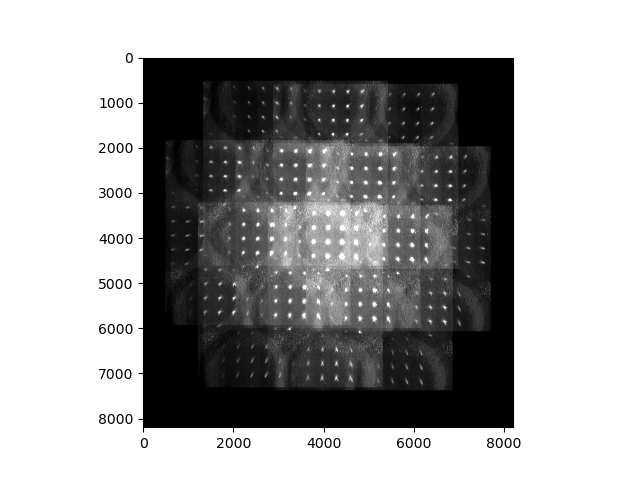

In [ ]:
plt.close()
#plt.imshow(torch.abs(torch.real(torch.fft.ifftshift(torch.fft.irfft2(torch.mul(ex_inv_fft, torch.fft.rfft2(img)))))/1e6), vmin=0, vmax=1e-11)
#plt.imshow(torch.angle(ex_inv_fft))
plt.imshow(torch.fft.ifftshift(torch.abs(torch.fft.irfft2(torch.mul(ex_fwd_fft, torch.fft.rfft2(img))))), vmin=0, vmax=25, cmap='gray')
#plt.imshow(torch.clamp(torch.fft.irfft2(torch.mul(ex_inv_fft, ones)).real, min=0))

# Just the Peaks

In [1]:
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib widget

In [2]:
import cv2 as cv
import scipy.signal as signal
import numpy as np
import gc

In [3]:
def convfft(image,kernel):
    # Assumes that the image and the kernel are the same size
    # Assumes that the image and the kernel are square
    # Assumes that the image and the kernel have been 2nified.
    
    image_fft = torch.fft.fft2(image.to(torch.float32), norm = 'backward')
    kernel_fft = torch.fft.fft2(kernel.to(torch.float32), norm = 'backward')
    fft_output = torch.mul(image_fft, kernel_fft)
    
    result = torch.fft.ifftshift(torch.abs(torch.fft.ifft2(fft_output, norm= 'backward'))).to(torch.float32)
    
    # Set edges to zero
    result[0:int(kernel.shape[0]/4), :] = result[int(3*kernel.shape[0]/4):, :] = result[:, :int(kernel.shape[1]/4)] = result[:, int(3*kernel.shape[1]/4):] = 0
    return result

In [4]:
def box_mask(img, PSF, square_length, tolerance):
        box_kernel = torch.zeros(img.shape).to(cpu_option)
        box_kernel[int(img.shape[0]/2)-int(square_length/2):int(img.shape[0]/2)+int(square_length/2), int(img.shape[1]/2)-int(square_length/2):int(img.shape[1]/2)+int(square_length/2)] = 1
        peaks = forward_projection[(len(forward_projection[:,0,0])//2),:,:].to(cpu_option)
        mask_box = convfft(peaks, box_kernel)
        mask_box[mask_box <= tolerance] = 0
        mask_box[mask_box > tolerance] = 1
        mask_box = torch.mul(mask_box, img)
        
        return mask_box

In [12]:
example_psf = torch.load(r'./charles_data/Ht_rev_2n.pt')[0,:,:]

In [5]:
import scipy.signal as signal
import numpy as np

In [6]:
def peak_finder(PSF, order):
    
    peaks = []
    
    for i in range(PSF.shape[0]):
        arg_rel_min = signal.argrelmin(PSF[i,:,:].numpy(), order = order)
        
        arg_rel_min_x = arg_rel_min[0]
        arg_rel_min_y = arg_rel_min[1]
        
        close_points = np.where(np.diff(arg_rel_min_x) < 50)
        arg_rel_min_x = np.delete(arg_rel_min_x, close_points)
        arg_rel_min_y = np.delete(arg_rel_min_y, close_points)
        
        center_pixel = (np.average(arg_rel_min_x), np.average(arg_rel_min_y))
        
        arg_rel_min_x = np.append(arg_rel_min_x, center_pixel[0])
        arg_rel_min_y = np.append(arg_rel_min_y, center_pixel[1])
        
        arg_rel_min_coords_center = [arg_rel_min_x, arg_rel_min_y]
        
        peaks.append(arg_rel_min_coords_center)
    
    return peaks

In [10]:
test = peak_finder(example_psf.unsqueeze(0), 45)

In [11]:
print(test[0])

[array([2650.        , 2716.        , 3896.        , 4027.        ,
       5205.        , 5267.        , 3960.16666667]), array([3418.        , 4889.        , 2626.        , 5576.        ,
       3301.        , 4777.        , 4097.83333333])]


In [25]:
def peak_inverter(PSF, box_size, cutoff_frequency, butterworth_order):
    # Grab a region around the peak of the PSF, and invert it in the fourier domain
    # The PSF should be in the format of [depth, x, y]

    x = torch.linspace(-box_size//2, box_size//2, box_size)
    y = torch.linspace(-box_size//2, box_size//2, box_size)
    x, y = torch.meshgrid(x, y, indexing = 'xy')
    
    # Define the Butterworth filter
    def butterworth(x,y,fc,n):
        return 1 / (1 + (torch.sqrt(x**2 + y**2)/fc)**(2*n))
    
    # Define a circular mask
    def circ(x,y,fc):
        return (x**2 + y**2 <= fc**2).to(torch.float32)
    
    def peak_finder(PSF, order):
        peaks = []
        for i in range(PSF.shape[0]):
            arg_rel_min = signal.argrelmin(PSF[i,:,:].numpy(), order = order)
            
            arg_rel_min_x = arg_rel_min[0]
            arg_rel_min_y = arg_rel_min[1]
            
            close_points = np.where(np.diff(arg_rel_min_x) < 50)
            arg_rel_min_x = np.delete(arg_rel_min_x, close_points)
            arg_rel_min_y = np.delete(arg_rel_min_y, close_points)
            
            center_pixel = (np.average(arg_rel_min_x), np.average(arg_rel_min_y))
            
            arg_rel_min_x = np.append(arg_rel_min_x, center_pixel[0])
            arg_rel_min_y = np.append(arg_rel_min_y, center_pixel[1])
            
            arg_rel_min_coords_center = [arg_rel_min_x, arg_rel_min_y]
            
            peaks.append(arg_rel_min_coords_center)
        
            return peaks
    
    peak_locations = peak_finder(PSF, 40)
    peak_storage = torch.empty(PSF.shape[0], len(peak_locations[0][0]), box_size, box_size)
    
    # grab each of the boxes
    for i in range(PSF.shape[0]):
        for j in range(len(peak_locations[0][0])):
            peak_storage[i,j,:,:] = PSF[i, int(peak_locations[i][0][j]-int(box_size/2)):int(peak_locations[i][0][j]+int(box_size/2)), int(peak_locations[i][1][j]-int(box_size/2)):int(peak_locations[i][1][j]+int(box_size/2))] # boxsize x boxsize
    
    fft_results_butter = torch.empty(peak_storage.shape).to(torch.complex64)
    
    # Pad them to be 2n for the FFT
    peak_storage = torch.nn.functional.pad(peak_storage, (int(box_size/2),int(box_size/2),int(box_size/2),int(box_size/2)), mode = 'constant', value = 0) # 2*boxsize x 2*boxsize
    
    # Grab the peaks of the PSF and find the FFT of the peaks
    fft_results = torch.fft.fftn(peak_storage, dim = (2,3))
    
    for i in range(PSF.shape[0]):
        for j in range(len(peak_locations[0][0])):
            fft_results_butter[i,j,:,:] = fft_results[i,j,1*int(box_size/2):3*int(box_size/2),1*int(box_size/2):3*int(box_size/2)]
            #fft_results_butter[i,j,:,:] = torch.mul(butterworth(x,y,cutoff_frequency,butterworth_order).to(torch.complex64), fft_results[i,j,1*int(box_size/2):3*int(box_size/2),1*int(box_size/2):3*int(box_size/2)])
    
    inversion = torch.abs((torch.fft.ifftn(torch.div(1e-6, 1e-6*fft_results_butter), dim = (2,3))))
    inversion = circ(x,y,cutoff_frequency) * inversion
    
    # Place the newly inverted PSF back into the PSF
    inverted_psf = torch.zeros(PSF.shape)
    for i in range(PSF.shape[0]):
        for j in range(len(peak_locations[0][0])):
            inverted_psf[i, int(peak_locations[i][0][j]-int(box_size/2)):int(peak_locations[i][0][j]+int(box_size/2)),int(peak_locations[i][1][j]-int(box_size/2)):int(peak_locations[i][1][j]+int(box_size/2))] = inversion[i,j,:,:]

    #del fft_results, fft_results_butter, inversion, peak_storage, peak_locations, fft_results_butter, x, y
    #gc.collect()
    
    return inverted_psf

In [20]:
inverted_psf = peak_inverter(example_psf.unsqueeze(0), 400, 40, 10)

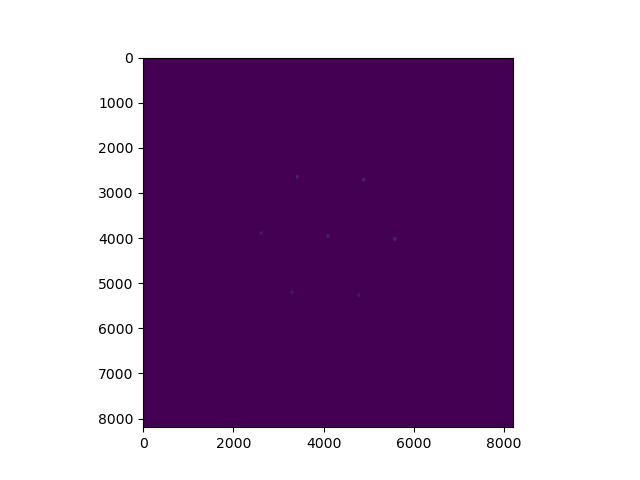

In [21]:
plt.close()
plt.imshow(inverted_psf[0,:,:])

In [85]:
norm_inverted_psf = torch.nan_to_num(torch.div(inverted_psf, torch.sum(inverted_psf, dim = (0), keepdim = True)), nan = 0, posinf=0, neginf=0)

In [76]:
print(inverted_psf.shape)

torch.Size([1, 8192, 8192])


In [77]:
imgs = torch.load(r'./charles_data/undeformed_2n.pt')

In [22]:
import torchvision.transforms as transforms

In [86]:
image_rotation = transforms.RandomRotation(degrees=(180,180))(norm_inverted_psf)

In [87]:
test_results = convfft(transforms.RandomRotation(degrees=(180,180))(1e-8*norm_inverted_psf[0].unsqueeze(0)).squeeze(0), imgs[0])

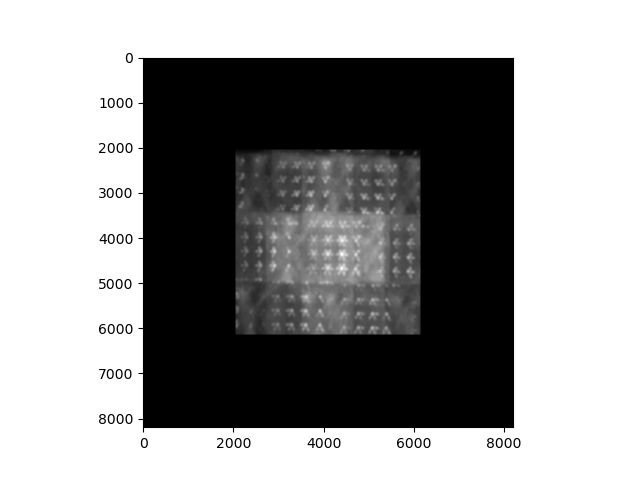

In [ ]:
plt.close()
plt.imshow(test_results[:,:], cmap='gray')

In [89]:
example_psforward = torch.load(r'./charles_data/Ht_rev_2n.pt')[0,:,:]

In [90]:
comparison = convfft(example_psforward, imgs[0])

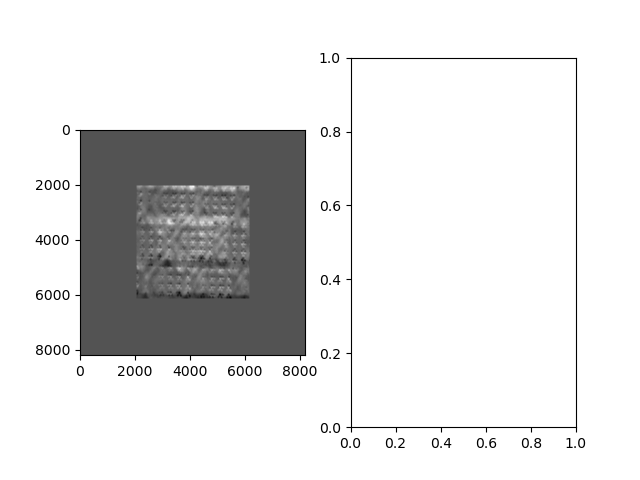

In [93]:
plt.close()
fig, ax = plt.subplots(1,2)
ax[0].imshow(comparison-(1e2*test_results), cmap='gray')
#ax[1].imshow(test_results*1e2, cmap='gray')

In [26]:
depth = 21
empty_tensor = torch.empty(depth, 8192, 8192)
for i in range(depth):
    psf = torch.load(r'./charles_data/H_rev_2n.pt')[i,:,:]
    inv_psf = torch.tensor(peak_inverter(psf.unsqueeze(0), 400, 40, 10))
    inv_psf = transforms.RandomRotation(degrees=(180,180))(torch.nan_to_num(torch.div(inv_psf, torch.sum(inv_psf, (0,), True)), nan = 0, posinf=0, neginf=0))
    empty_tensor[i,:,:] = inv_psf

C:\Users\admin\AppData\Local\Temp\ipykernel_15468\3450905798.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inv_psf = torch.tensor(peak_inverter(psf.unsqueeze(0), 400, 40, 10))


ValueError: cannot convert float NaN to integer

In [ ]:
torch.save(empty_tensor, r'./charles_data/Ht_rev_2n_inv.pt')

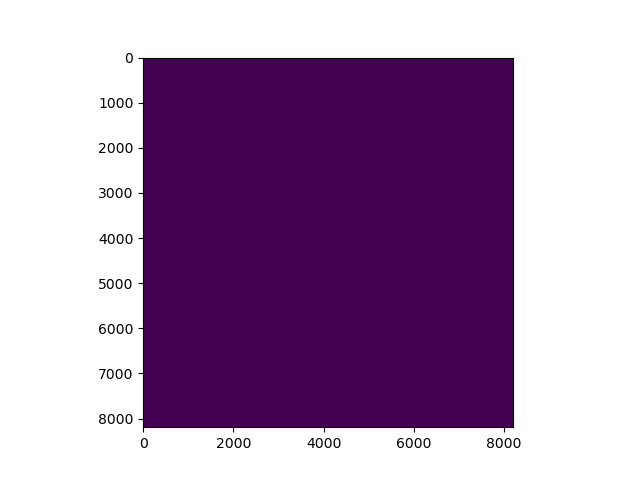

In [ ]:
plt.close()
plt.imshow(empty_tensor[1,:,:])

In [25]:
cv.imwrite('./charles_data/psf.tiff', example_psforward.numpy())
cv.imwrite('./charles_data/inverted.tiff', inverted_psf[0].numpy())

True

In [96]:
import gc

In [107]:
gc.collect()
gc.

AttributeError: module 'gc' has no attribute 'empty_cache'